# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [2]:
print(data.head(5))

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

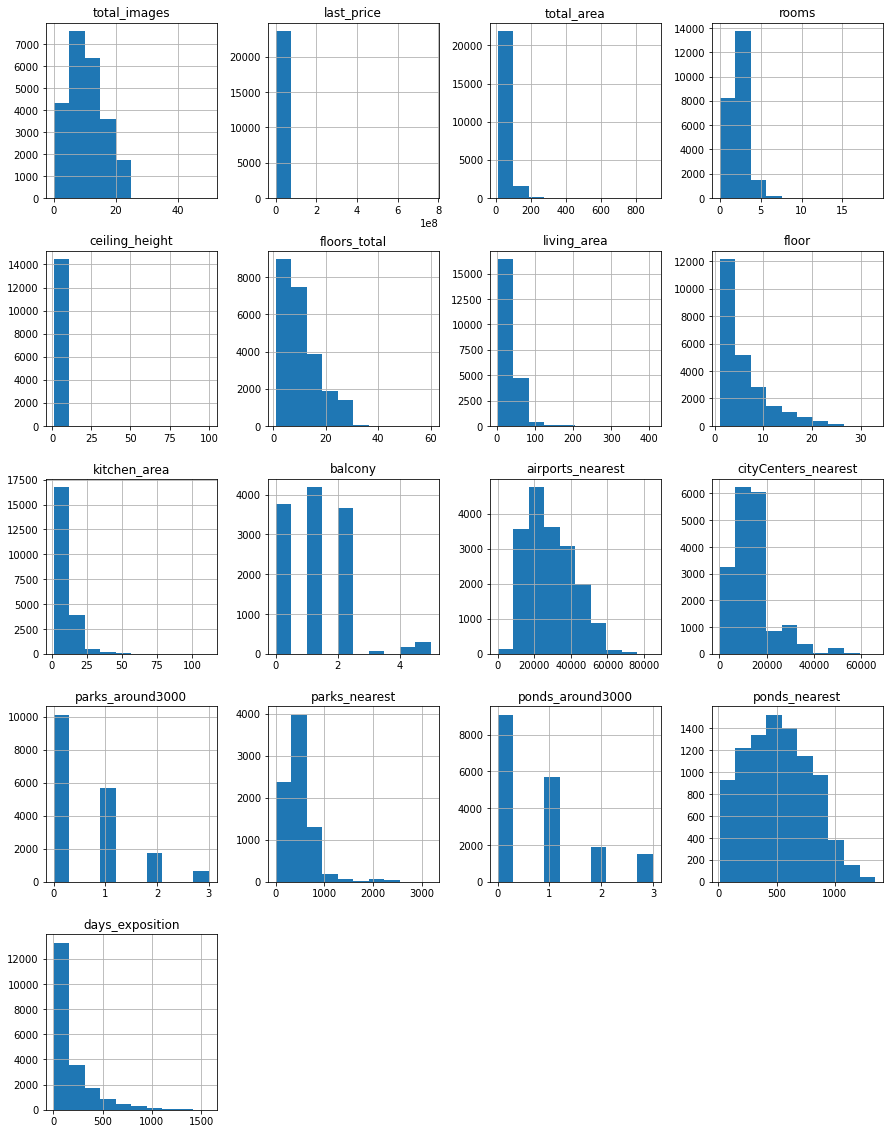

In [3]:
data.hist(figsize=(15, 20))

### Предобработка данных

In [4]:
data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [5]:
data['ceiling_height'] =  data['ceiling_height'].fillna(data['ceiling_height'].median()) 
data['balcony'] = data['balcony'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

In [6]:
median_la = data['living_area'].median()
median_ta = data['total_area'].median()
ratio = median_la/median_ta
data['living_area'] = data['living_area'].fillna(ratio*data['total_area'])

median_ka = data['kitchen_area'].median()
ratio = median_ka/median_ta
data['kitchen_area'] = data['kitchen_area'].fillna(ratio*data['total_area'])

**Возможные причины**
Если продавец не указал число балконов, то, скорее всего, в его квартире их нет; по этой же логике я заменила пропущенные значения в столбцах parks_around3000 и ponds_around3000 на 0. Так же я заменила пропущенные значения в столбце ceiling_height на медианное значение, так как в большинстве случаев высота потолков стандартная и составляет 2.5 - 2.7 м.

Так же я сомневалась насчет столбца is_apartment, так как апартаменты отличаются от квартиры лишь тем, что эта площадь не зарегистрирована как жилая, то есть там нельзя будет прописаться и тд. Решила оставить, как есть, так как нельзя точно сказать, что большинство пропусков в этом столбце - это однозначно ДА или однозначно НЕТ.

Пропуски в других столбцах я решила не заменять, так как нельзя заменить на логичное подходящее значение. Пропуски могли появляться из-за невнимательности заполнения анкеты, из-за незнания территории (сколько метров до парка или есть ли они вообще) или из-за отсутствия подходящего ответа(например, объявление опубликовали, но квартиру еще не сняли, поэтому не совсем понятно, что писать в графе days_exposition)

In [7]:
data['is_apartment'] = data['is_apartment'].astype('bool')
data['balcony'] = data['balcony'].astype('int')
#data['days_exposition'] = data['days_exposition'].astype('int')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S')

Столбец is_apartment должен иметь тип bool, так как значения столбца должны давать ответ на вопрос "Является ли объект апартаментами?", то есть подразумевается ответ Да\Нет.Столбец balcony должен иметь тип int, так как количество балконов - это целое число. Столбец  first_day_exposition я перевела в дату, чтобы была возможность использовать отдельные части даты и времени.

In [8]:
data['locality_name'].value_counts()
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [9]:
def name(row):
    try: 
        if 'посёлок' in row:
            row1 = row.replace('посёлок','поселок')
            return row1
        else:
            return row
    except:
            return row

def name1(row):
    try: 
        if 'городского типа' in row:
            row1 = row.replace(' городского типа','')
            return row1
        elif 'городской поселок' in row:
            row2 = row.replace(' городской поселок','')
            return row2
        else:
            return row
    except:
            return row
data['locality_name'] = data['locality_name'].apply(name)
data['locality_name'] = data['locality_name'].apply(name1)

In [10]:
def anomal_value_ceiling_height(row):
    if (row > 5) & (row <20):
        row = None
        return row
    elif row > 20:
        row = row/10
        return row
    else:
        return row
data['ceiling_height'] = data['ceiling_height'].apply(anomal_value_ceiling_height)

In [11]:
# Код ревьюера
data.update(data[(data['ceiling_height'] >= 20) & (data['ceiling_height'] <= 36)]['ceiling_height']/10)

In [12]:
print(data[data['balcony'] > 5])

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition]
Index: []

[0 rows x 22 columns]


In [13]:
print(data['days_exposition'].max())
print(data['days_exposition'].min())
print(data['days_exposition'].median())
print(data['days_exposition'].mean())
anomal = data[data['days_exposition'] > 730]
#print(anomal)

1580.0
1.0
95.0
180.88863436982163


In [14]:
print(data['floor'].max())
print(data['floor'].min())

33
1


In [15]:
print(data['floors_total'].max())
print(data['floors_total'].min())

60.0
1.0


In [16]:
print(data['kitchen_area'].max())
print(data['kitchen_area'].min())
#print(data[data['kitchen_area'] < 3])

112.0
1.3


In [17]:
print(data['living_area'].max())
print(data['living_area'].min())
#print(data[data['living_area'] > 350])

409.7
2.0


In [18]:
print(data['total_images'].max())
print(data['total_images'].min())

50
0


In [19]:
#print(data['last_price'].max())
#print(data['last_price'].min())
data.loc[8793,'last_price'] = None
print(data['last_price'].min())

430000.0


**Вывод по аномальным значениям:**
При анализе аномальных значений в столбце ceiling_height я удалила значения от 5 до 20 метров, так как потолки в жилых помещениях не могут быть такой высоты (высокими потолки считаются уже от 3м, а высота от 5 - это аномалия), а допустить ошибку ( не там поставить запятую в разряде) допустить не могли, так как получилось бы слишком маленькое значение. 

Также я проверила и другие столбцы, выводя максимальное и минимальное значения (оставила как пример не все). Например, в столбце days_exposition максимальное значение равно примерно 4.3 года, при среднем и медианном значениях 95 и 180 дней. Но я вывела все строки, у которых значение этого столбца > 730 ( больше 2-х лет), и там  получилось 72 строки, то есть, в целом, это вполне допустимое значение.  А вот в столбце last_price было одно аномальное значение - двухкомнатная квартира в Санкт-Петербурге за 12 000.Эту цену пришлось удалить, так как явно она не соответствует действительности.

Аналогично я поступила и с другими столбцами, меня так же насторожили значения площади кухни 1.3м^2 и значение в living_area равное 409 м, но я так же проверила еще несколько строк с похожими показателями, и выяснила, что маленькие кухни встречаются в квартирах с 1 комнатой или студиях, а у квариты с показателем 409м 12 комнат, так что это тоже вполне допустимые значения.

### Посчитайте и добавьте в таблицу новые столбцы

In [20]:
data['square_meter_price'] = round(data['last_price']/data['total_area'],2)

# вычисление стоимости квадратного метра

In [21]:
data['day_of_the_week'] = data['first_day_exposition'].dt.weekday

# вычисление дня недели публикации

In [22]:
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month

# вычисление года и месяца публикации

In [29]:
import numpy as np
fg = np.where(pd.DatetimeIndex(data['first_day_exposition']).year == 2018,1,0)
print(fg)
data['first_day_exposition'].min()

[0 1 0 ... 1 0 0]


Timestamp('2014-11-27 00:00:00')

In [23]:
for i in range(data.count()[0]):
    if data.loc[i,'floor'] == 1:
        data.loc[i,'type_of_floor'] = 'первый'
    elif data.loc[i,'floor'] == data.loc[i,'floors_total']:
        data.loc[i,'type_of_floor'] = "последний"
    else:
        data.loc[i,'type_of_floor']  = 'другой'
        
# вычисление типа этажа квартиры

In [24]:
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest']/1000)

# вычисление расстояния до центра в км

### Проведите исследовательский анализ данных

Text(0.5, 1.0, 'total_area')

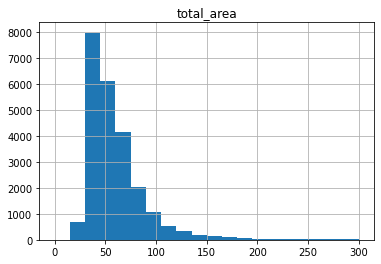

In [25]:
data['total_area'].hist(bins = 20,range = (0,300))
plt.title(label = 'total_area')

Text(0.5, 1.0, 'living_area')

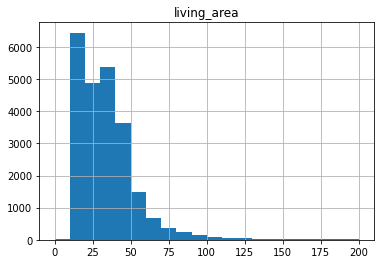

In [26]:
data['living_area'].hist(bins = 20,range = (0,200))
plt.title(label = 'living_area')

Text(0.5, 1.0, 'kitchen_area')

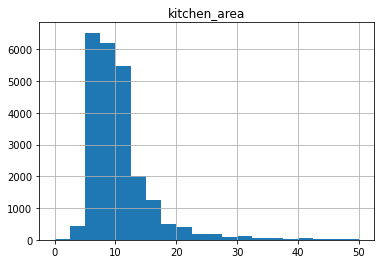

In [27]:
data['kitchen_area'].hist(bins = 20,range = (0,50))
plt.title(label = 'kitchen_area')

Text(0.5, 1.0, 'last_price')

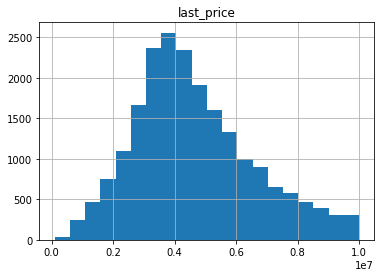

In [28]:
data['last_price'].hist(bins = 20,range = (100000,10000000))
plt.title(label = 'last_price')

Text(0.5, 1.0, 'rooms')

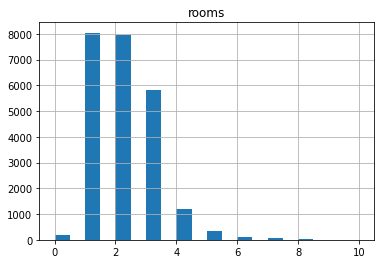

In [29]:
data['rooms'].hist(bins = 20,range = (0,10))
plt.title(label = 'rooms')

Text(0.5, 1.0, 'ceiling_height')

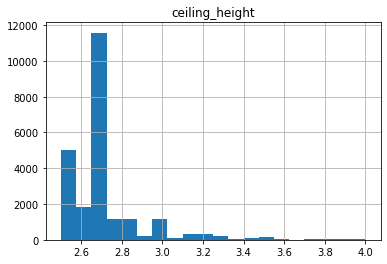

In [30]:
data['ceiling_height'].hist(bins = 20,range = (2.5,4))
plt.title(label = 'ceiling_height')

Text(0.5, 1.0, 'floor')

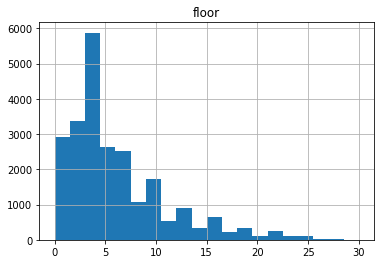

In [31]:
data['floor'].hist(bins = 20,range = (0,30))
plt.title(label = 'floor')

Text(0.5, 1.0, 'type_of_floor')

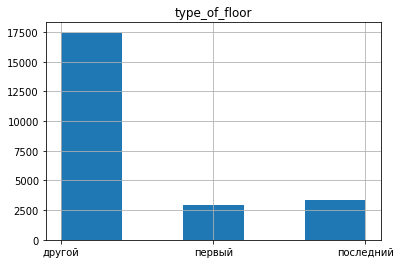

In [32]:
data['type_of_floor'].hist(bins = 5)
plt.title(label = 'type_of_floor')

Text(0.5, 1.0, 'floors_total')

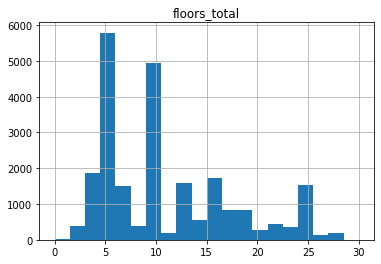

In [33]:
data['floors_total'].hist(bins = 20,range = (0,30))
plt.title(label = 'floors_total')

Text(0.5, 1.0, 'cityCenters_nearest')

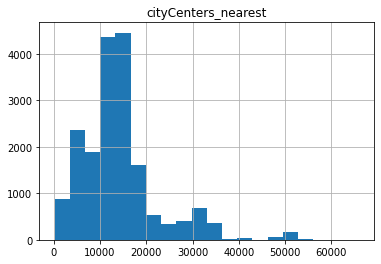

In [34]:
data['cityCenters_nearest'].hist(bins = 20)
plt.title(label = 'cityCenters_nearest')

Text(0.5, 1.0, 'airports_nearest')

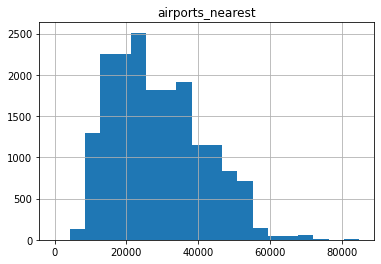

In [35]:
data['airports_nearest'].hist(bins = 20)
plt.title(label = 'airports_nearest')

Text(0.5, 1.0, 'parks_nearest')

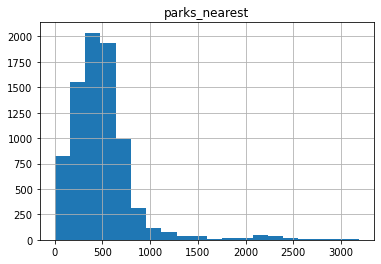

In [36]:
data['parks_nearest'].hist(bins = 20)
plt.title(label = 'parks_nearest')

Text(0.5, 1.0, 'month')

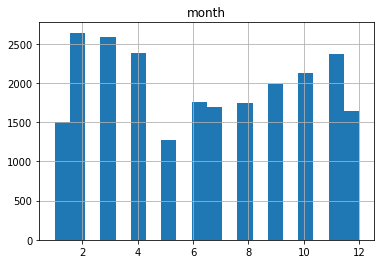

In [37]:
data['month'].hist(bins = 20)
plt.title(label = 'month')

Text(0.5, 1.0, 'day_of_the_week')

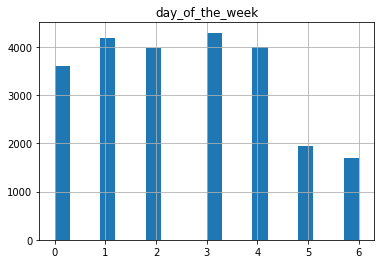

In [38]:
data['day_of_the_week'].hist(bins = 20)
plt.title(label = 'day_of_the_week')

Общий комментарий:
Мы видим, что большинство квартир имеют площадь 40-70 кв.м., и от 120 кв.м. идет маленький хвост, поэтому можно сказать, что доля квартир, с площадью более 120 кв.м. достаточно мала. Аналогичный вывод можно сделать и параметры living_area и kitchen_area, обычно жилая площадь имеет размер д0 60 кв.м, а кухня - до 20 кв.м.

Самое большое количество квартир выставляется с ценой в промежутке от 2000000 до 6000000 руб.
Больше всего квартир с 1, 2 или 3 комнатами, высотой потолков 2.7м, и до 5 этажа, когда этажей в доме либо около 5, либо около 10.
Категория "другой" намного популярнее, чем "первый" и "последний". Расстояние от аэропорта чаще всего составляет от 20 до 40 км, расстояние до ближайшего парка около 250-600м. А вот на двух последних диаграммах можно увидеть, что срежи дней недели и среди месяцев нет какого-то определенного лидера.

95.0


180.88863436982163

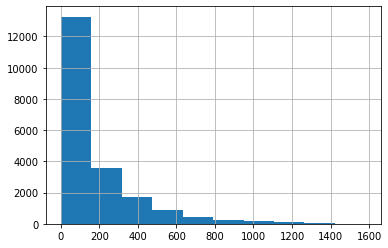

In [39]:
data['days_exposition'].hist()
print(data['days_exposition'].median())
data['days_exposition'].mean()

Медианное значение периода, за который продавались квартиры, составляет около 3-х месяце, среднее - полгода. Блягодаря гистограмме мы видим, что есть квартиры, которые продавались около 4-лет, но большинство квартир продалось менее, чем за год. Можно сказать, что быстро проданная квартира - та, у которой значение периода продажи лежит в интервале до 3-х месяцев, а долгие продажи начинаются примерно от 1 года.

0.6537402377092495


<AxesSubplot:xlabel='total_area', ylabel='last_price'>

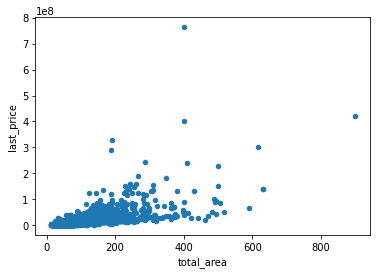

In [40]:
print(data['last_price'].corr(data['total_area']))
data.plot(x='total_area', y='last_price', kind='scatter')

0.5145168801495118


<AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>

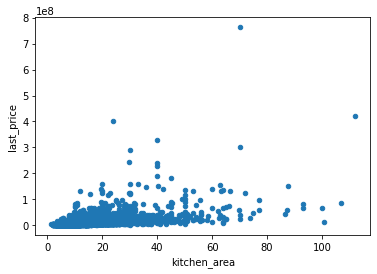

In [41]:
print(data['last_price'].corr(data['kitchen_area']))
data.plot(x='kitchen_area', y='last_price', kind='scatter')

0.5858924190461742


<AxesSubplot:xlabel='living_area', ylabel='last_price'>

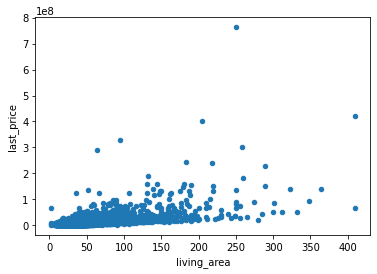

In [42]:
print(data['last_price'].corr(data['living_area']))
data.plot(x='living_area', y='last_price', kind='scatter')

0.36334398266009404


<AxesSubplot:xlabel='rooms', ylabel='last_price'>

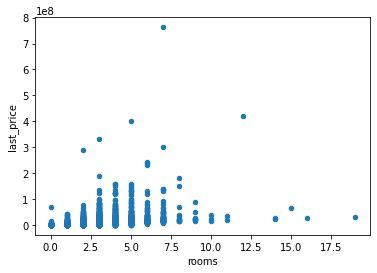

In [43]:
print(data['last_price'].corr(data['rooms']))
data.plot(x='rooms', y='last_price', kind='scatter')

<AxesSubplot:xlabel='type_of_floor', ylabel='last_price'>

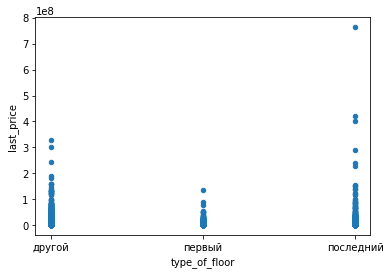

In [44]:
#print(data['last_price'].corr(data['type_of_floor']))
data.plot(x='type_of_floor', y='last_price', kind='scatter')

0.0015421067200722702


<AxesSubplot:xlabel='day_of_the_week', ylabel='last_price'>

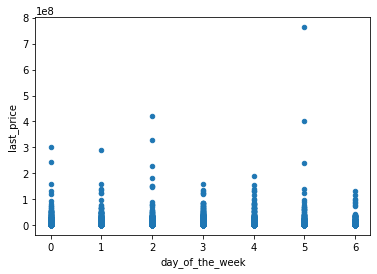

In [45]:
print(data['last_price'].corr(data['day_of_the_week']))
data.plot(x='day_of_the_week', y='last_price', kind='scatter')

0.0027545590999158557


<AxesSubplot:xlabel='month', ylabel='last_price'>

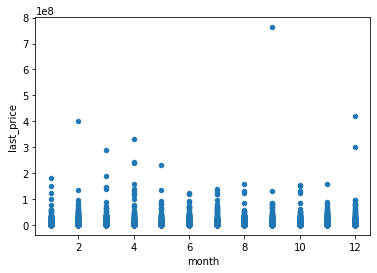

In [46]:
print(data['last_price'].corr(data['month']))
data.plot(x='month', y='last_price', kind='scatter')

-0.04305185858515465


<AxesSubplot:xlabel='year', ylabel='last_price'>

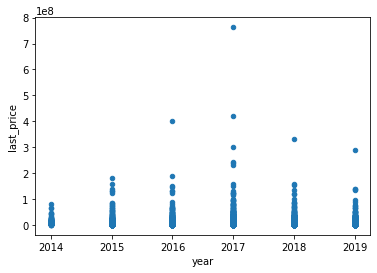

In [51]:
print(data['last_price'].corr(data['year']))
data.plot(x='year', y='last_price', kind='scatter')

Я изучила связь между ценой и некоторыми параметрами. Оказалось, существует хорошая линейная связь с ценой и площадью, с количеством комнат она чуть слабее, а с этажом, днем недели, месяцем и годом продажи связи почти нет.

In [52]:
names  = pd.Series(data['locality_name'].unique()).sort_values()
d = pd.pivot_table(data, index ='locality_name', values = 'square_meter_price' )
for i in names:
    d.loc[i,'count_publications'] = data[data['locality_name'] == i].count()[0]
d = d[d['count_publications']!=0]
print(d.sort_values(by = 'count_publications',ascending = False).head(1))
print(d.sort_values(by = 'count_publications').head(1))

                 square_meter_price  count_publications
locality_name                                          
Санкт-Петербург       114856.307596             15721.0
                            square_meter_price  count_publications
locality_name                                                     
коттеджный поселок Счастье            64583.33                 1.0


In [53]:
data['price_km'] = round(data['last_price']/data['cityCenters_nearest_km'],2)
df = data[data['locality_name'] == 'Санкт-Петербург']
print(data['last_price'].corr(data['cityCenters_nearest_km']))
print(df[['last_price','cityCenters_nearest_km','price_km']].head(10))

-0.20702013146777962
    last_price  cityCenters_nearest_km    price_km
0   13000000.0                    16.0   812500.00
2    5196000.0                    14.0   371142.86
3   64900000.0                     7.0  9271428.57
4   10000000.0                     8.0  1250000.00
7    7915000.0                    12.0   659583.33
9    5400000.0                    15.0   360000.00
10   5050000.0                    14.0   360714.29
15   4650000.0                    14.0   332142.86
16   6700000.0                    11.0   609090.91
17   4180000.0                    15.0   278666.67


-0.20702013146777962


<AxesSubplot:xlabel='cityCenters_nearest_km', ylabel='last_price'>

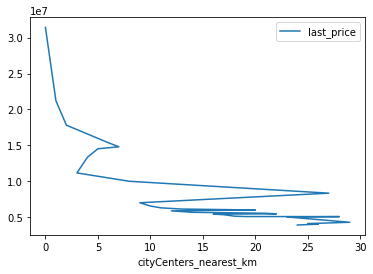

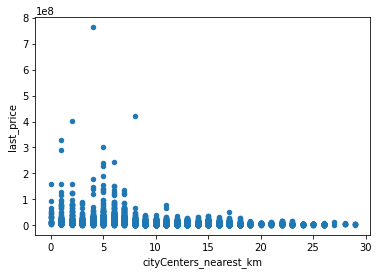

In [63]:
df = data[data['locality_name'] == 'Санкт-Петербург']
d = pd.pivot_table(df,index = 'cityCenters_nearest_km',values = 'last_price')
d = d.sort_values(by = 'last_price')
print(data['last_price'].corr(data['cityCenters_nearest_km']))

d.plot( y='last_price')
df.plot( x = 'cityCenters_nearest_km',y = 'last_price',kind = 'scatter')

Коэффицент корреляции отрицательный и не очень большой по модулю, поэтому можно сделать вывод, что связь есть, но не очень сильная (чем меньще расстояние, тем больше цена).

### Общий вывод

**ВЫВОД:**
При выполнении проекта были сделаны следующие шаги: предобработка данных,корректировка значений и добавление новых столбцов, исследовательский анализ. 

На первом этапе я изучила общую информацию о данных, обработала пропуски (либо вставив медианное значение, либо логически подходящее), избавилась от неявных дубликатов, изменила некоторые типы данных на нужные и устранила аномальные значения - сделала все для корректной работы с данные в последующих шагах.

На втором этапе я добавила в таблицу новые столбцы, которые могут быть удобны для обработки данных, а также которые лучше отражают какие-то конкретные характеристики.

На третьем этапе я построила гистограммы для некоторых параметров, изучила связь между ценой и некоторыми из них. Оказалось, существует хорошая линейная связь с ценой и площадью, с количеством комнат она чуть слабее, а с этажом, днем недели, месяцем и годом продажи связи почти нет. Так же есть слабая связь с расстоянием до центра - чем меньще расстояние, тем больше цена.
